# SArt - classificador de pinturas

Neste projeto, serão usados conceitos de machine learning a fim de classificar estilos de pinturas de quadros, baseado na leitura da imagem. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import cv2
import os
import PIL
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy

## Base de dados

A base de dados usada foi: https://archive.org/details/wikiart-dataset

São disponibilizadas pastas, nomeadas com um estilo artístico e tendo como conteúdo as obras de arte feitas dentro deste estilo. 

- A estrutura é dada por: `<estilo>/nome-artista_nome-pintura-ano.jpg`
    - Exemplo: `Realism/vincent-van-gogh_pine-trees-in-the-fen-1884.jpg`

O primeiro tratamento feito na base de dados foi excluir movimentos artísticos com um número de obras de arte infferior a 1000. Depois, foram considerados movimentos apenas constituintes de **pinturas**.

Esses cortes foram feitos de maneira manual.

In [4]:
dados = pd.read_excel('wclasses.xlsx')

In [5]:
len(dados)

81444

Além das imagens, o wikiArt disponibiliza um excel, cujas colunas são o path das imagens, ids dos artistas, gênero e estilo.

A lista a seguir possui os nomes dos estilos considerados para o projeto, após aplicarmos os tratamentos citados.

In [6]:
classesList =["Abstrac_Expressionism","Art_Nouveau_Modern","Baroque","Color_Field_Painting","Cubism","Early_Renaissance",
"Expressionism", "Fauvismo","High_Renaissance","Impressionism","Mannerism_Late_Renaissance","Minimalism",
"Naive_Art_Primitivism","Northen_Renaissance","Pop_Art","Post_Impressionism","Realism","Rococo","Romanticism","Symbolism",
"Ukiyo_e"]

Aplicando o filtro com os nomes dos estilos que serão usados:

In [2]:
#impor_membros= dados["file"].str.contains(*classesList)

mask = dados.iloc[:, 0].str.contains(r'\b(?:{})\b'.format('|'.join(classesList)))
df1 = dados[~mask]
len(df1)


NameError: name 'dados' is not defined

In [14]:
df1.head(20)

,file,artist,genre,style
8,Northern_Renaissance/albrecht-durer_deposition...,25,136,157
31,Northern_Renaissance/albrecht-durer_apostle-ba...,25,136,157
46,Northern_Renaissance/albrecht-durer_laughing-p...,25,135,157
60,Northern_Renaissance/albrecht-durer_portrait-o...,25,135,157
61,Northern_Renaissance/albrecht-durer_the-penite...,25,131,157
70,Northern_Renaissance/albrecht-durer_portrait-o...,25,135,157
100,Northern_Renaissance/albrecht-durer_the-great-...,25,131,157
125,Northern_Renaissance/albrecht-durer_portrait-o...,25,135,157
147,Northern_Renaissance/albrecht-durer_portrait-o...,25,135,157
166,Northern_Renaissance/albrecht-durer_portrait-o...,25,135,157


In [11]:
os.getcwd()

'D:\\Libraries\\Documents\\Insper\\Machine Learning\\SArt'

Arrumando o nome dos arquivos que tem acento para facilitar o uso do path das imagens.

In [15]:

f = r"D:/Libraries/Documents/Insper/Machine Learning/SArt"
for img_p in range(df1.shape[0]):
    img_path = df1.iloc[img_p, 0]
    if "Ã¢Â\xa0" in img_path:
        img_path = img_path.replace('Ã¢Â', '\u00E2')
        temp_path = img_path.replace('\u00E2', 'a') 
        df1.iat[img_p, 0] = temp_path
        img_path = f  + "/" + img_path
        temp_path = f  + "/" + temp_path
        os.rename(u'{0}'.format(img_path), temp_path)
        img_path = temp_path
    
    df1.iat[img_p, 3] = df1.iloc[img_p, 3]-140
    img = Image.open(img_path)
    img = img.resize((256,256))
    img.save(img_path)

Separação treinamento e teste
- 80% da base de dados destinada a treinamento
- O tipo do id do estilo foi passado de `int` para `str` para possibilitar a classificação  categórica no image generator.

In [16]:
df1.loc[:,'style'] = df1['style'].astype(str)
print(df1.dtypes)

train = df1.sample(frac=0.8,random_state=200)
test = df1.drop(train.index)

file      object
artist     int64
genre      int64
style     object
dtype: object


C:\Users\Beatriz\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [17]:
print(type(df1.iloc[10, 3]))

<class 'str'>


## Redes neurais 

Para classificar as imagens, foram aplicadas três redes neurais:
- CNN
- LeNet5
- ResNet-152

Os resultados obtidos serão comparados no final.

### Aplicando rede CNN - Convolutional neural network

A rede convolucional foi escolhida, pois é comumente aplicada para análise de imagens visuais. Para essa rede, foi usado o tutorial do próprio tensorflow.

A rede convolucional pega um input de imagem e atribui importânca (pesos e vieses que podem ser aprendidos) para objetos nela, conseguindo diferenciá-los entre si.

O pré-processamento dessa rede é muito menor quando comparado a outros algoritmos de classificação. Enquanto métodos de filtro mais primitivos são hand-engineered (ou seja, feitos à mão), a rede convolucional, com treinamento suficiente, consegue aprender esses filtros.

<img src="rgb_imgcnn.jpg" style="height: 250px;"/>   

<img src="fully_connected_layer.jpg" style="height: 300px;"/>   

In [18]:
im = cv2.imread(train.iloc[4, 0])
print(im.shape)

(256, 256, 3)


A seguir, foram montadas as camadas da rede, conforme explicado no tutorial do tensorflow

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 230400)            0

O `ImageDataGenerator()` divide os sets em dados que podem ser usados pelo tensorflow. Para validação, são usados 20% dos dados de treino.

A seguir, o set de treino é dividido em treino e validação.

In [34]:
target_size=(256,256) # set the size of the images
color_mode='rgb' # set the type of image
class_mode= 'categorical' # set the class mode
batch_size=64  # set the batch size

train_gen = ImageDataGenerator(validation_split=0.2)
test_gen = ImageDataGenerator()

train_imgs= train_gen.flow_from_dataframe(dataframe=train, 
          x_col='file',
          y_col='style',
          target_size=target_size,color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size,shuffle=True, seed=123,
          subset='training')
val_imgs= train_gen.flow_from_dataframe(dataframe=train, 
          x_col='file',
          y_col='style',
          target_size=target_size,color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size,shuffle=True, seed=123,
          subset="validation")
test_imgs= test_gen.flow_from_dataframe(dataframe=test, 
          x_col='file',
          y_col='style',
          target_size=target_size,color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size,shuffle=True, seed=123,
          subset='training')

Found 5120 validated image filenames belonging to 9 classes.
Found 1280 validated image filenames belonging to 9 classes.
Found 1600 validated image filenames belonging to 9 classes.


In [22]:
test['style'].value_counts()

0     569
17    531
10    173
18     99
6      91
16     67
25     37
2      19
1      14
Name: style, dtype: int64

In [23]:
train.head()

,file,artist,genre,style
18175,Northern_Renaissance/albrecht-durer_dead-blueb...,0,139,17
78398,Fauvism/charles-lapicque_bateau-sur-la-lagune-...,0,139,10
71978,Abstract_Expressionism/elaine-de-kooning_portr...,0,139,0
6566,Pointillism/camille-pissarro_portrait-of-nini-...,2,135,18
29226,Pointillism/georges-seurat_suburb-1882.jpg,47,130,18


In [24]:
model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

history = model.fit(train_imgs, epochs=30, 
                    validation_data=val_imgs)

<class 'numpy.ndarray'>
Epoch 1/30
80/80 [==============================] - 43s 417ms/step - loss: 57.4578 - accuracy: 0.3182 - val_loss: 1.8884 - val_accuracy: 0.3789
Epoch 2/30
80/80 [==============================] - 12s 149ms/step - loss: 1.7320 - accuracy: 0.4219 - val_loss: 1.9267 - val_accuracy: 0.3828
Epoch 3/30
80/80 [==============================] - 12s 148ms/step - loss: 1.7485 - accuracy: 0.4162 - val_loss: 1.7875 - val_accuracy: 0.3961
Epoch 4/30
80/80 [==============================] - 12s 151ms/step - loss: 1.3825 - accuracy: 0.5141 - val_loss: 1.9569 - val_accuracy: 0.3703
Epoch 5/30
80/80 [==============================] - 12s 154ms/step - loss: 1.0505 - accuracy: 0.6225 - val_loss: 2.1190 - val_accuracy: 0.3734
Epoch 6/30
80/80 [==============================] - 12s 149ms/step - loss: 0.8067 - accuracy: 0.7107 - val_loss: 2.9213 - val_accuracy: 0.3836
Epoch 7/30
80/80 [==============================] - 12s 152ms/step - loss: 0.6805 - accuracy: 0.7527 - val_loss: 3.21

25/25 - 3s - loss: 9.8698 - accuracy: 0.3169 - 3s/epoch - 132ms/step


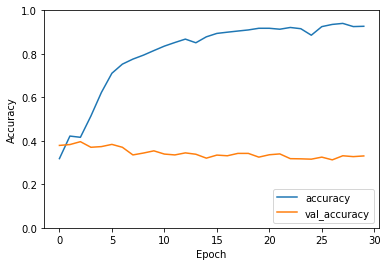

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_imgs, verbose=2)

O gráfico acima mostra a acurácia para os dados de treino (em azul) e dados de teste (em laranja). Como se pode ver, a acurácia dos dados de treino se apresenta maior, dado que o modelo está com overfitting, ou seja, para dados fora daqueles usados para o treinamento, o modelo não conseguiu obter um bom ajuste.

In [101]:
# print(train_imgs)
x,y = next(iter(train_imgs))
print(x.shape)

(32, 256, 256, 3)


In [102]:
print(y.shape)

(32, 9)


In [103]:
print(y[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0.]


### Aplicando LeNet

**LeNet** é uma estrutura de rede neural convolucional, introduzida no paper _"Gradient-Based Learning Applied To Document Recognition"_ em 1998, de autoria de Yann LeCun, Leon Bottou, Yoshua Bengio e Patrick Haffner.

Como será mostrado a seguir, a LeNet é composta por 7 layers, cuja composição é:
- 3 layers convolucionais
- 2 layers de subamostragem
- 2 layers totalmente conectados

<img src="LeNetArchitecture.jpg" style="height: 250px;"/>   

A seguir, são montadas as camadas, conforme a estrutura da rede.

In [30]:
LeNet5 = tf.keras.Sequential()

LeNet5.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)))
LeNet5.add(layers.AveragePooling2D())

LeNet5.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
LeNet5.add(layers.AveragePooling2D())

LeNet5.add(layers.Flatten())

LeNet5.add(layers.Dense(120, activation='relu'))

LeNet5.add(layers.Dense(84, activation='relu'))

LeNet5.add(layers.Dense(9, activation = 'softmax'))

LeNet5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 average_pooling2d_2 (Averag  (None, 127, 127, 6)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 16)      880       
                                                                 
 average_pooling2d_3 (Averag  (None, 62, 62, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 61504)             0         
                                                                 
 dense_5 (Dense)             (None, 120)              

In [31]:
LeNet5.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

historyLeNet5 = LeNet5.fit(train_imgs, epochs=30, 
                    validation_data=val_imgs)

Epoch 1/30
80/80 [==============================] - 13s 155ms/step - loss: 23.3071 - accuracy: 0.3393 - val_loss: 1.6006 - val_accuracy: 0.4547
Epoch 2/30
80/80 [==============================] - 12s 155ms/step - loss: 1.1315 - accuracy: 0.6326 - val_loss: 1.5324 - val_accuracy: 0.5008
Epoch 3/30
80/80 [==============================] - 12s 152ms/step - loss: 0.5328 - accuracy: 0.8506 - val_loss: 1.6160 - val_accuracy: 0.5312
Epoch 4/30
80/80 [==============================] - 12s 151ms/step - loss: 0.2276 - accuracy: 0.9512 - val_loss: 1.8558 - val_accuracy: 0.5336
Epoch 5/30
80/80 [==============================] - 12s 151ms/step - loss: 0.1083 - accuracy: 0.9824 - val_loss: 2.0627 - val_accuracy: 0.5156
Epoch 6/30
80/80 [==============================] - 12s 155ms/step - loss: 0.0754 - accuracy: 0.9936 - val_loss: 2.2474 - val_accuracy: 0.5352
Epoch 7/30
80/80 [==============================] - 12s 152ms/step - loss: 0.0538 - accuracy: 0.9949 - val_loss: 2.3286 - val_accuracy: 0.522

25/25 - 3s - loss: 3.1853 - accuracy: 0.5400 - 3s/epoch - 130ms/step


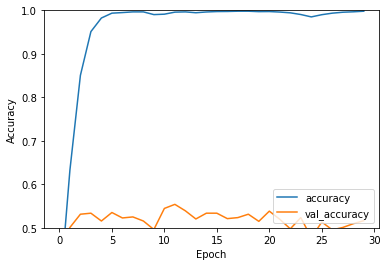

In [33]:
plt.plot(historyLeNet5.history['accuracy'], label='accuracy')
plt.plot(historyLeNet5.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = LeNet5.evaluate(test_imgs, verbose=2)

Como mostrado no gráfico acima, também se apresentou overfitting, com a acurácia do treinamento muito maior do que no caso do teste.